In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pyart
import pytda
import awot
import pyradarmet
from netCDF4 import date2num
from awot.graph import create_basemap, FlightLevel, RadarHorizontalPlot
%matplotlib inline

In [2]:
filename = '/Users/guy/data/pecan/nex2/kuex/KUEX20150611_031925_V06.gz'
os.system('gzip -d '+filename)
rKUEX = pyart.aux_io.read_radx(filename[:-3])
os.system('gzip '+filename[:-3])

fCHILL = '/Users/guy/data/t28/tcad1999/CHILL/chill_cfrad_turb_19990611_210817.nc'
rfiles = sorted(glob.glob(os.path.join('/Users/guy/data/t28/tcad1999/', 'CHILL')+'/chill*.nc'))
rCHILL = pyart.io.read(fCHILL)

In [3]:
def join_radars(r1, r2):
    rj = pyart.core.radar.join_radar(r1, r2)
    return rj

rflist = []
for filen, filer in enumerate(rfiles):
    rflist.append(pyart.io.read(filer))

rCHILLj = join_radars(rflist[0], rflist[1])
for rad in rflist[2:]:
    rCHILLj = join_radars(rCHILLj, rad)

In [4]:
name_map = {
#        'time': 'time',
            # Aircraft Position
            'longitude': 'LONC',
            'latitude': 'LATC',
            'altitude': 'ztrue',
            'pressure_altitude': 'PALT',
            'tas': 'tas',
            'ias': 'aias',
            'true_heading': 'AVthead',
            'pitch': 'AVpitch',
            'roll_angle': 'AVroll',
            # Atmospheric State
            'pressure': 'pmb',
            'temperature': 'trf',
            'dewpoint_temperature': 'tdplicor',
            'thetad': 'thetad',
            'thetae': 'thetae',
            'relative_humidity': 'rh',
            'mixing_ratio': 'mr',
            'lwc': 'lwc100',
            'turb': 'turb',
            'g_accel': 'avnorma',
            # Radiometric
            'irtop': 'irtc',
            'irbottom': 'irbc',
            'swtop': 'swt',
            'swbottom': 'swb',
            # Wind derivations
            'Uwind': 'avuwind',
            'Vwind': 'avvwind',
            'Wwind': 'avwwind',
            'longitudinal_wind': 'avux',
            'latitudinal_wind': 'avvy',
            'wind_dir': 'avwdir',
            'wind_spd': 'axwmag',
            # Licor Concentrations
            'co2_conc': 'co21s',
            'h2o_conc': 'h2o1s',
            # Aerosol
            'pcasp_num': 'AS200_OBR',
            'pcasp_conc': 'CS200_OBR',
            'pcasp_mean_diam': 'DBARP_OBR',
            'pcasp_surf_area_conc': 'PSFCP_OBR',
            'pcasp_vol_conc': 'PVOLP_OBR',
            # Cloud Physics
            'conc_cpc': 'cpc_conc',
            # Miscellaneous
            'topo': 'topo'}

#flight = awot.io.read_netcdf(os.path.join('/Users/guy/data/pecan', '20150611.c50.nc'), mapping_dict=name_map)
flight1Hz = awot.io.read_netcdf(os.path.join('/Users/guy/data/pecan', '20150611.c1.nc'), mapping_dict=name_map)
flt28 = awot.io.read_netcdf(os.path.join('/Users/guy/data/t28/tcad1999','flight', 'T28_TCAD1999_728.nc'), time_var='Time', platform='T-28')

Using 'time' to make AWOT time variable
Using 'Time' to make AWOT time variable


In [5]:
bwKUEX = rKUEX.instrument_parameters['radar_beam_width_h']['data'][0]

In [6]:
# Run PyTDA on the KUEX radar instance
pytda.calc_turb_vol(rKUEX, name_sw='SW', name_dz='REF', verbose=False,
                    gate_spacing=250.0/1000.0, use_ntda=False, beamwidth=bwKUEX)

In [7]:
uwka_set = ["2015-06-11 03:18:00", "2015-06-11 03:22:00"]
lonl, latl = [-99., -97], [39.5, 41.]
radsweep = 2
rnglim, htlim, reflim, turblim = (0., 75.), (0., 5.), (0., 60.), (0., 1.)
rlat, rlon = rKUEX.latitude['data'][0], rKUEX.longitude['data'][0]

t28_set = ["1999-06-11 21:06:00", "1999-06-11 21:15:00"]
lonlt28, latlt28 = [-104.8, -103.7], [40.7, 41.3]
chsweep = 4
chlat, chlon = rCHILL.latitude['data'][0], rCHILL.longitude['data'][0]

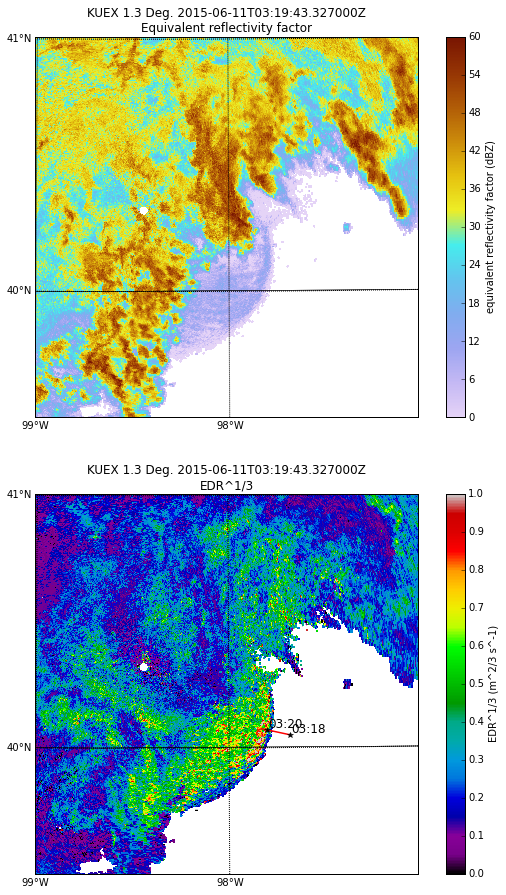

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10.0, 15.))
displayKUEX = pyart.graph.RadarMapDisplay(rKUEX)
#ax = fig.add_subplot(nrows, 2, index+1)
displayKUEX.plot_ppi_map('REF', radsweep, vmin=0., vmax=60.,
            min_lon=lonl[0], max_lon=lonl[1], min_lat=latl[0], max_lat=latl[1],
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='l',
            lat_0=rlat, lon_0=rlon, colorbar_flag=False, ax=ax1)
displayKUEX.plot_colorbar(ax=ax1)
f2 = FlightLevel(flight1Hz, basemap=displayKUEX.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=uwka_set[0], end_time=uwka_set[1],)
f2.time_stamps(start_time=uwka_set[0], end_time=uwka_set[1],
                           labelspacing=120)


displayKUEX.plot_ppi_map('turbulence', radsweep, vmin=0., vmax=1.,
            min_lon=lonl[0], max_lon=lonl[1], min_lat=latl[0], max_lat=latl[1],
            cmap='nipy_spectral',projection='aeqd', resolution='l',
            lat_0=rlat, lon_0=rlon, colorbar_flag=False, ax=ax2)
displayKUEX.plot_colorbar(ax=ax2)

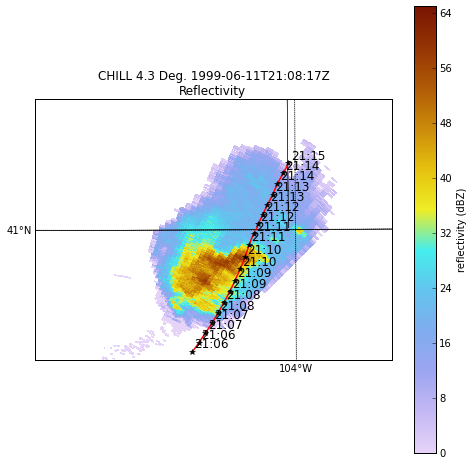

In [9]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8.0, 8.))
displayCHILL = pyart.graph.RadarMapDisplay(rCHILL)
#ax = fig.add_subplot(nrows, 2, index+1)
displayCHILL.plot_ppi_map('DZ', chsweep, vmin=0., vmax=65.,
            min_lon=lonlt28[0], max_lon=lonlt28[1], min_lat=latlt28[0], max_lat=latlt28[1],
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='l',
            lat_0=chlat, lon_0=chlon, ax=ax1)
f2 = FlightLevel(flt28, basemap=displayCHILL.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=t28_set[0], end_time=t28_set[1],)
f2.time_stamps(start_time=t28_set[0], end_time=t28_set[1],
                           labelspacing=600)

In [10]:
 def calc_latlon_time(radar, basemap=None):
    rng, az = np.meshgrid(radar.range['data'], radar.azimuth['data'])
    rng, ele = np.meshgrid(radar.range['data'], radar.elevation['data'])
    rng, time = np.meshgrid(radar.range['data'], radar.time['data'])
    theta_e = np.radians(ele)       # elevation angle in radians.
    theta_a = np.radians(az)        # azimuth angle in radians.
    Re = 6371000. * 4.0 / 3.0     # effective radius of earth in meters.

    z = (rng ** 2 + Re ** 2 + 2.0 * rng * Re * np.sin(theta_e)) ** 0.5 - Re
    s = Re * np.arcsin(rng * np.cos(theta_e) / (Re + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
 
    if basemap is not None:
        lon, lat = basemap(x, y, inverse=True)
    else:
        c = np.sqrt(x*x + y*y) / rng
        phi_0 = np.radians(radar.latitude['data'])
        azi = np.arctan2(y, x)  # from east to north

        lat = np.degrees(np.arcsin(np.cos(c) * np.sin(phi_0) +
                        np.sin(azi) * np.sin(c) * np.cos(phi_0)))
        lon = np.degrees(np.arctan2(np.cos(azi) * np.sin(c), np.cos(c) * np.cos(phi_0) -
               np.sin(azi) * np.sin(c) * np.sin(phi_0))) + radar.longitude['data']
        lon = np.fmod(lon + 180, 360) - 180

    lat_axis = {
        'data':  lat,
        'long_name': 'Latitude for points in Cartesian system',
        'axis': 'YX',
        'units': 'degree_N',
        'standard_name': 'latitude',
    }

    lon_axis = {
        'data': lon,
        'long_name': 'Longitude for points in Cartesian system',
        'axis': 'YX',
        'units': 'degree_E',
        'standard_name': 'longitude',
    }
    
    time2D = {
        'data': time,
        'long_name': radar.time['long_name'],
        'units': radar.time['units'],
        'standard_name': radar.time['standard_name'],
    }
    return lat_axis, lon_axis, time2D

def calculate_gate_locations(radar, basemap=None):
    rlat, rlon = radar.latitude['data'][0], radar.longitude['data'][0]
    ralt = radar.altitude['data'][0]
    gate_lat, gate_lon, gate_time = calc_latlon_time(radar, basemap=basemap)
    delLat = rlat - gate_lat['data'][:]
    delLon = rlon - gate_lon['data'][:]
    R = 6371000.
    a = (np.sin(np.radians(delLat)/2))**2 + np.cos(np.radians(rlat)) * np.cos(np.radians(rlat)) * (np.sin(np.radians(delLon)/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = R * c

    rng, elevs = np.meshgrid(radar.range['data'], radar.elevation['data'])
    
#    gate_heights = np.empty_like(d)
#    for nn in range(radar.ngates):
#        gate_heights[:, nn] = pyradarmet.geometry.ray_height(d[:, nn], elevs, radar.altitude['data'][0])
    gate_heights = pyradarmet.geometry.ray_height(d, elevs, ralt)
    gate_height = {
        'data': gate_heights,
        'long_name': 'Height of center of gate in Cartesian system',
        'units': 'meters',
        'standard_name': 'Gate height',
    }
    return gate_lat, gate_lon, gate_height, gate_time

In [11]:
rawotKUEX = awot.util.pyart_radar_to_awot(rKUEX)
gate_lat, gate_lon, gate_heights, gate_time = calculate_gate_locations(rKUEX, basemap=displayKUEX.basemap)
rawotKUEX['latitude'] = gate_lat
rawotKUEX['longitude'] = gate_lon
rawotKUEX['height'] = gate_heights
rawotKUEX['time'] = gate_time

In [12]:
rawotCHILL = awot.util.pyart_radar_to_awot(rCHILLj)
gate_lat, gate_lon, gate_heights, gate_time = calculate_gate_locations(rCHILLj, basemap=displayCHILL.basemap)
rawotCHILL['latitude'] = gate_lat
rawotCHILL['longitude'] = gate_lon
rawotCHILL['height'] = gate_heights
rawotCHILL['time'] = gate_time

-97.6832499205


ValueError: setting an array element with a sequence.

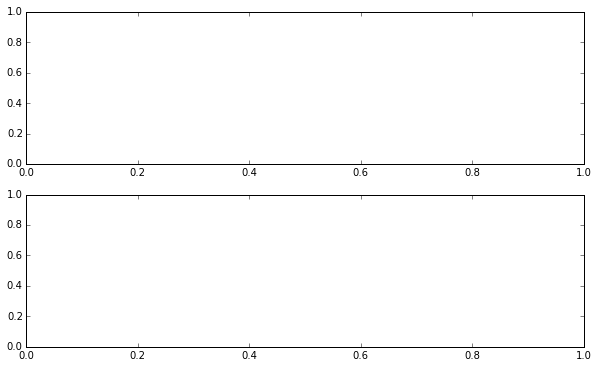

In [18]:
fig, (axXS1, axXS2) = plt.subplots(2, 1, figsize=(10,6))
f = FlightLevel(flight1Hz, basemap=displayKUEX.basemap)
f.plot_radar_cross_section(rawot, 'REF', cmap='pyart_LangRainbow12', cminmax=reflim,
                           start_time=uwka_set[0], end_time=uwka_set[1], ax=axXS1)
f.plot_radar_cross_section(rawot, 'SW', cmap='nipy_spectral', cminmax=turblim,
                           start_time=uwka_set[0], end_time=uwka_set[1], ax=axXS1)

In [13]:
matchKUEX = awot.util.TrackMatch(flight1Hz, rawotKUEX,
                           data_lon=rawotKUEX['longitude']['data'],
                           data_lat=rawotKUEX['latitude']['data'],
                           data_height=rawotKUEX['height']['data'],
                           data_time=rawotKUEX['time'],
                           start_time=uwka_set[0], end_time=uwka_set[1])

In [14]:
matchCHILL = awot.util.TrackMatch(flt28, rawotCHILL,
                           data_lon=rawotCHILL['longitude']['data'],
                           data_lat=rawotCHILL['latitude']['data'],
                           data_height=rawotCHILL['height']['data'],
                           data_time=rawotCHILL['time'],
                           start_time=t28_set[0], end_time=t28_set[1])

In [11]:
#match_near = data.near_neighbor_tunnel()
#match_near_pyart = matchKUEX.near_neighbor_pyart(rKUEX)

In [15]:
match_treeKUEX = matchKUEX.kdtree(use_time=True)

In [16]:
match_treeCHILL = matchCHILL.kdtree(use_time=True)

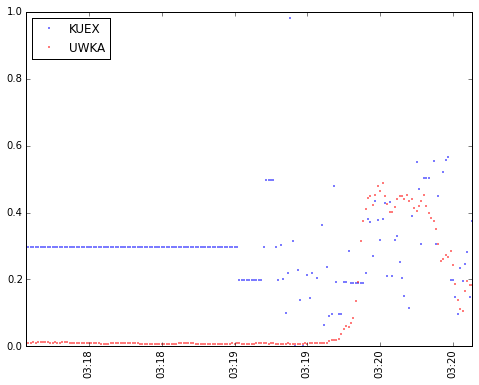

In [25]:
import matplotlib.dates as md
fig,ax = plt.subplots(1,1, figsize=(8,6))
plt.plot(match_treeKUEX.flight['time']['data'], match_treeKUEX.data['turbulence']['data'], '.b', 
         ms=2, label='KUEX')
plt.plot(match_treeKUEX.flight['time']['data'], match_treeKUEX.flight['turb']['data'], '.r', 
         ms=2, label='UWKA')
#plt.plot(match_near_pyart.flight['time']['data'], match_near_pyart.data['turbulence']['data'], 'og')
ax.set_ylim(0, 1)
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks(rotation=90)
plt.legend(numpoints=1, loc='upper left')

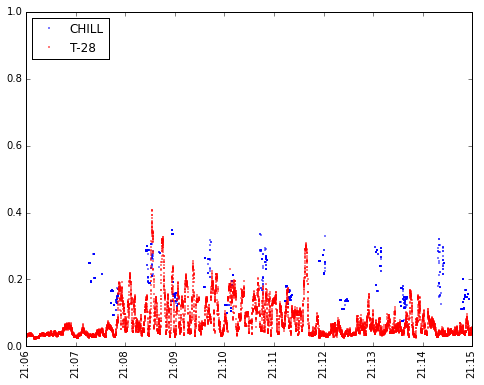

In [23]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
plt.plot(match_treeCHILL.flight['time']['data'], match_treeCHILL.data['turbulence']['data'], '.b', 
         ms=2, label='CHILL')
plt.plot(match_treeCHILL.flight['time']['data'], match_treeCHILL.flight['turb']['data']/100**0.6666667, '.r', 
         ms=2, label='T-28')
#plt.plot(match_treeCHILL.flight['time']['data'], match_treeCHILL.data['turb_no_ntda']['data'], '.g'))
ax.set_ylim(0, 1)
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks(rotation=90)
plt.legend(numpoints=1, loc='upper left')

In [19]:
print(rKUEX.range['data'].shape, rKUEX.azimuth['data'].shape, rKUEX.elevation['data'].shape,rKUEX.time['data'].shape)
print(rCHILL.range['data'].shape, rCHILL.azimuth['data'].shape, rCHILL.elevation['data'].shape,rCHILL.time['data'].shape)

(1832,) (6120,) (6120,) (6120,)
(800,) (798,) (798,) (798,)


In [20]:
print(match_treeCHILL.data['turbulence']['data'].min(), match_treeCHILL.data['turbulence']['data'].max())
print(flt28['time']['data'].min(), flt28['time']['data'].max())
print(match_treeCHILL.data.keys())

nan nan
1999-06-11 20:19:12 1999-06-11 21:45:03
[u'turb_no_ntda', u'VE', u'NC', u'LH', u'DZ', u'W2', u'turbulence']


In [21]:
from netCDF4 import date2num, num2date
tt= num2date(rCHILL.time['data'],rCHILL.time['units'])
nummy = date2num(tt, 'seconds since 1970-01-01 00:00:00Z')
rCHILLj.time['data'].shape
print(rawotCHILL['time']['data'].min(),rawotCHILL['time']['data'].max())
print(rCHILLj.time['data'].min(),rCHILLj.time['data'].max())
nummy.dtype

929135226.0 929135792.0
929135226.0 929135792.0


dtype('float64')